In [2]:
import pymc as pm, polars as pl
import matplotlib.pyplot as plt, numpy as np, xarray as xr
import arviz as az

In [3]:
df_foxes = pl.read_csv("../../Rethinking_2/End_of_chapter_problems/data/foxes.csv", separator=";")

In [4]:
df_foxes

group,avgfood,groupsize,area,weight
i64,f64,i64,f64,f64
1,0.37,2,1.09,5.02
1,0.37,2,1.09,2.84
2,0.53,2,2.05,5.33
2,0.53,2,2.05,6.07
3,0.49,2,2.12,5.85
…,…,…,…,…
29,0.67,4,2.75,4.81
29,0.67,4,2.75,3.94
30,0.41,3,1.91,3.16


In [6]:
df_foxes = df_foxes.with_columns((pl.exclude("group") - pl.exclude("group").mean())/pl.exclude("group").std())

array([[<Axes: ylabel='avgfood'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='groupsize'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='area'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: xlabel='group', ylabel='weight'>,
        <Axes: xlabel='avgfood'>, <Axes: xlabel='groupsize'>,
        <Axes: xlabel='area'>]], dtype=object)

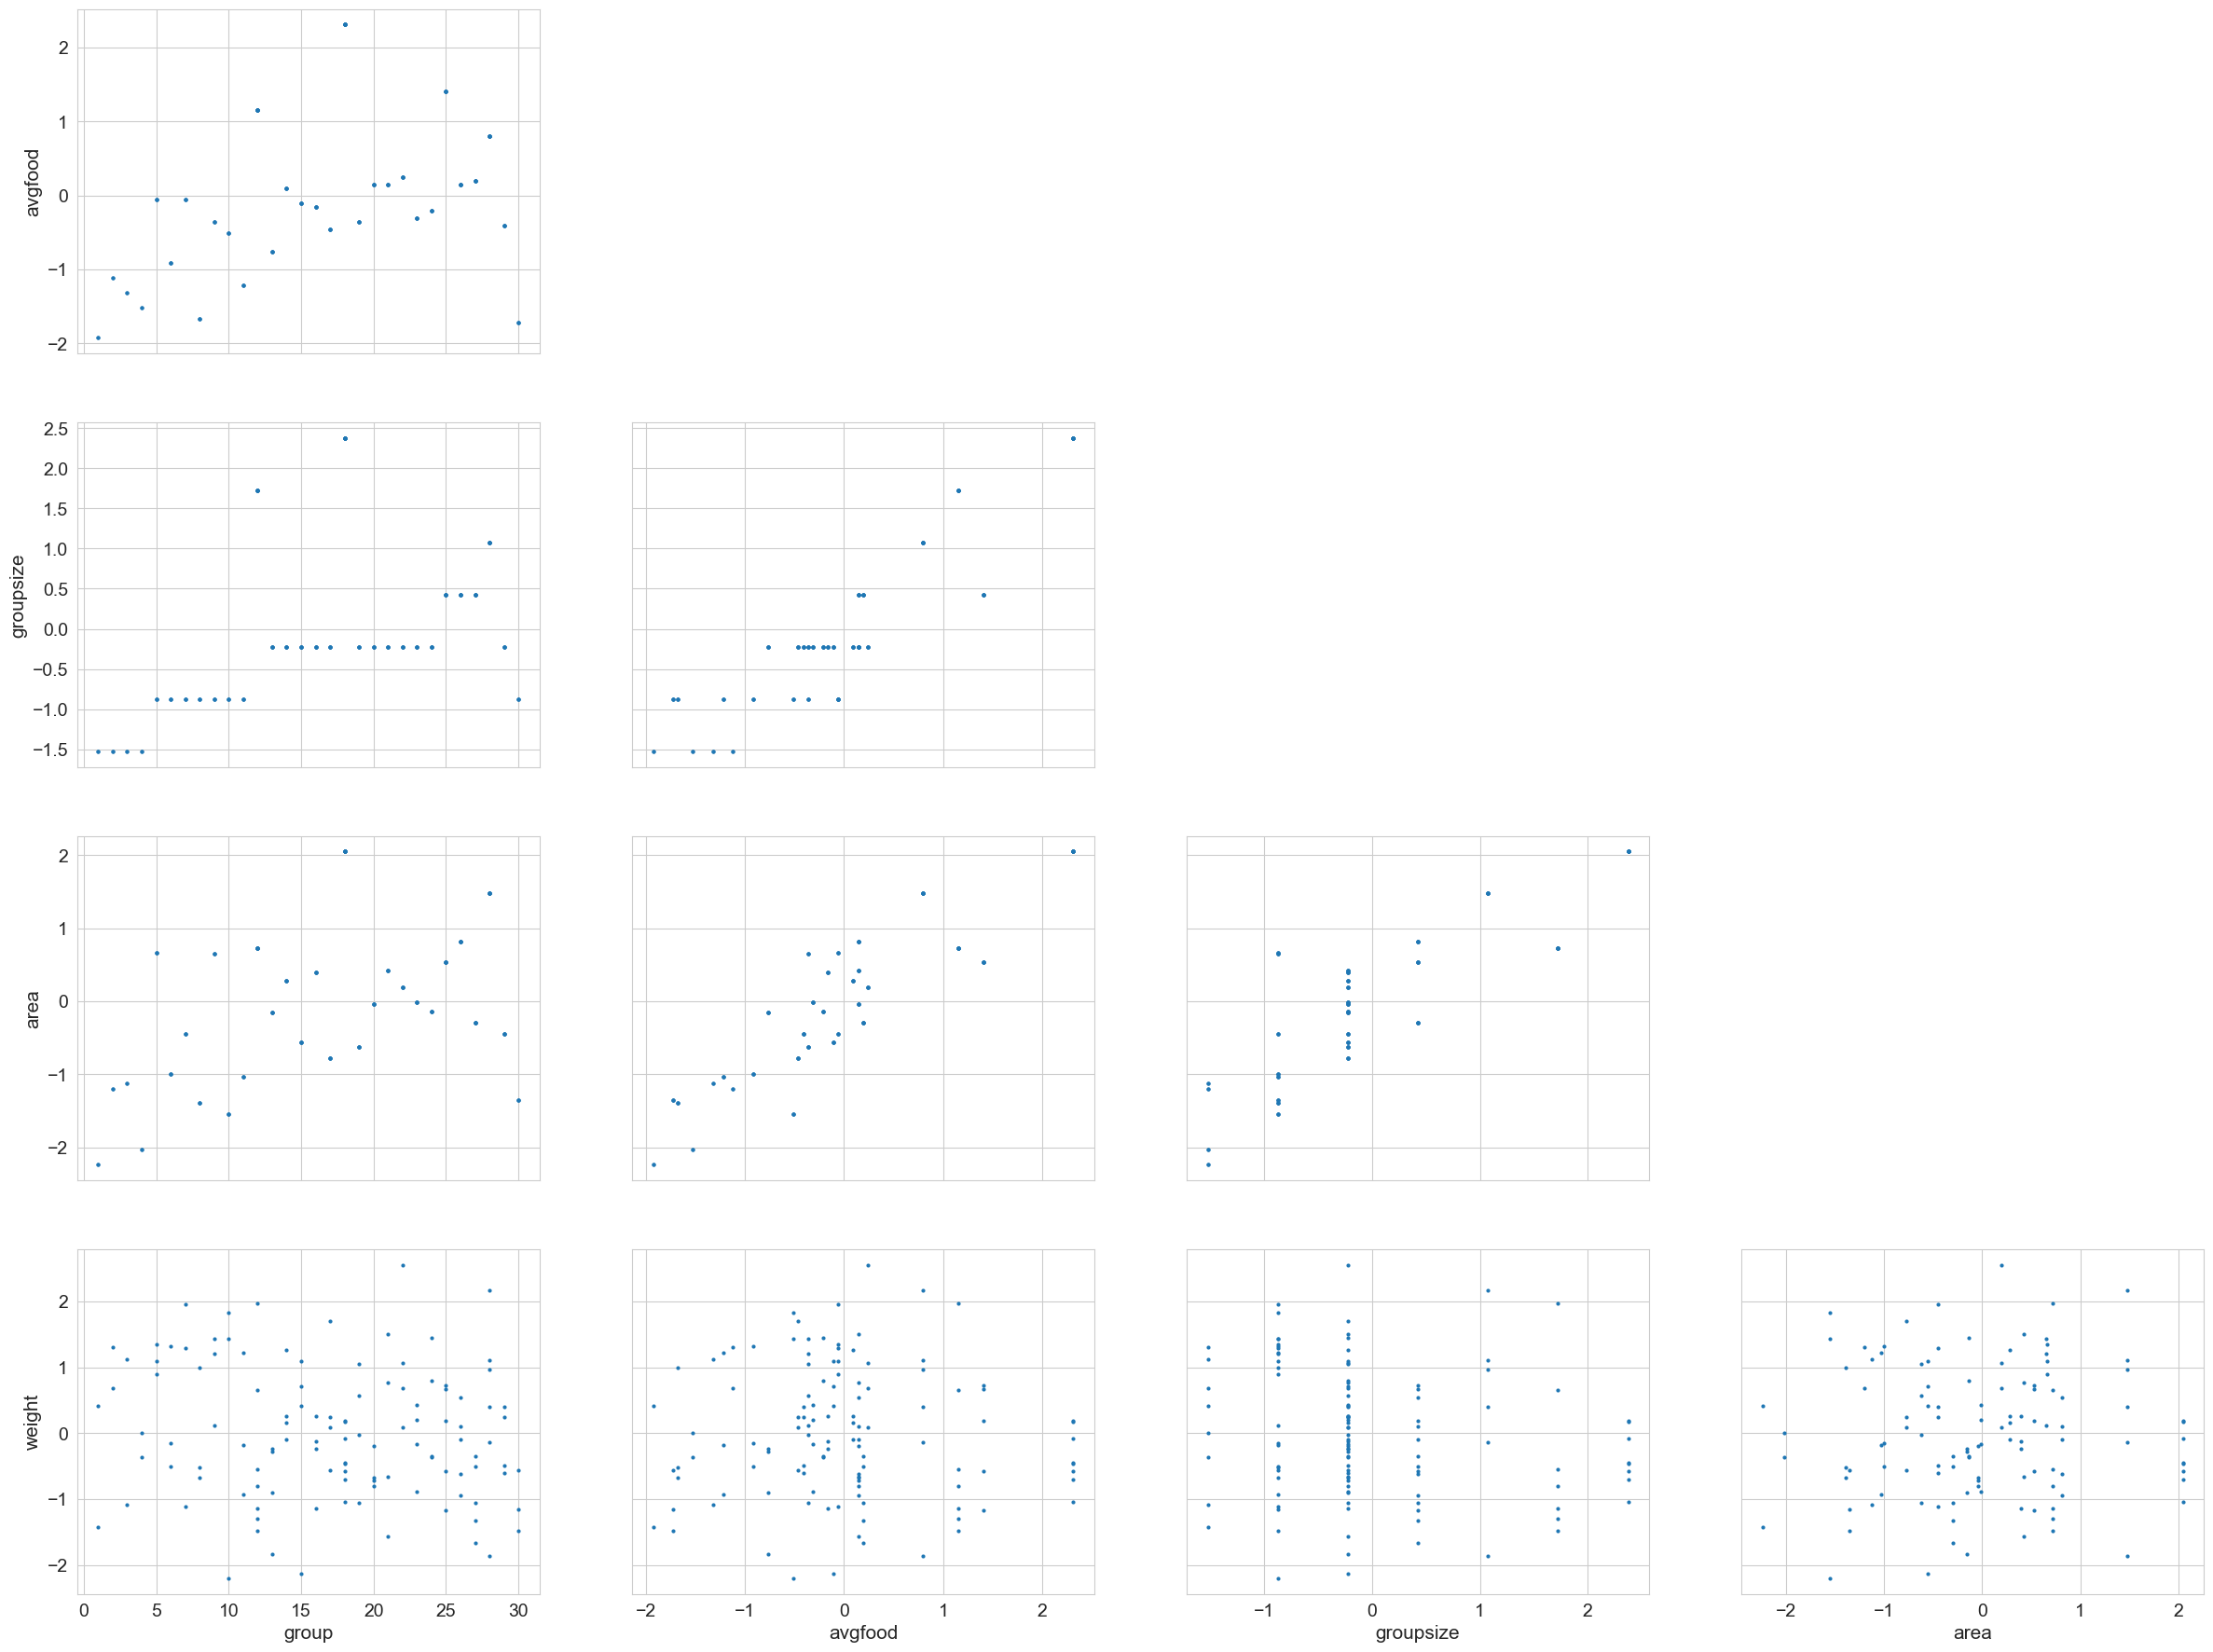

In [7]:
az.plot_pair(df_foxes.to_dict())

In [30]:
# model definition
with pm.Model() as basic_model:
    # priors
    alpha = pm.Normal('alpha', 0, 1)
    beta = pm.Normal('beta', 0, 0.5)
    sigma = pm.Exponential('sigma', 1)

    mu = alpha + beta*df_foxes["groupsize"].to_numpy()
    weight = pm.Normal('weight', mu, sigma, observed=df_foxes["weight"].to_numpy())

    # check prior predictive
    idata = pm.sample_prior_predictive(draws=100)

Sampling: [alpha, beta, sigma, weight]


Text(0.5, 1.0, 'Prior predictive checks -- Weakly regularizing priors')

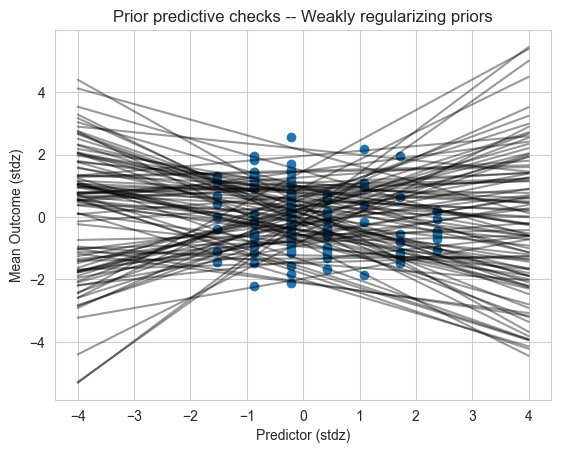

In [31]:
_, ax = plt.subplots()

x = xr.DataArray(np.linspace(-4, 4, 70), dims=["plot_dim"])
prior = idata.prior
y = prior["alpha"] + prior["beta"] * x

ax.plot(x, y.stack(sample=("chain", "draw")), c="k", alpha=0.4)
ax.scatter(df_foxes["groupsize"].to_numpy(), df_foxes["weight"].to_numpy())

ax.set_xlabel("Predictor (stdz)")
ax.set_ylabel("Mean Outcome (stdz)")
ax.set_title("Prior predictive checks -- Weakly regularizing priors")

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

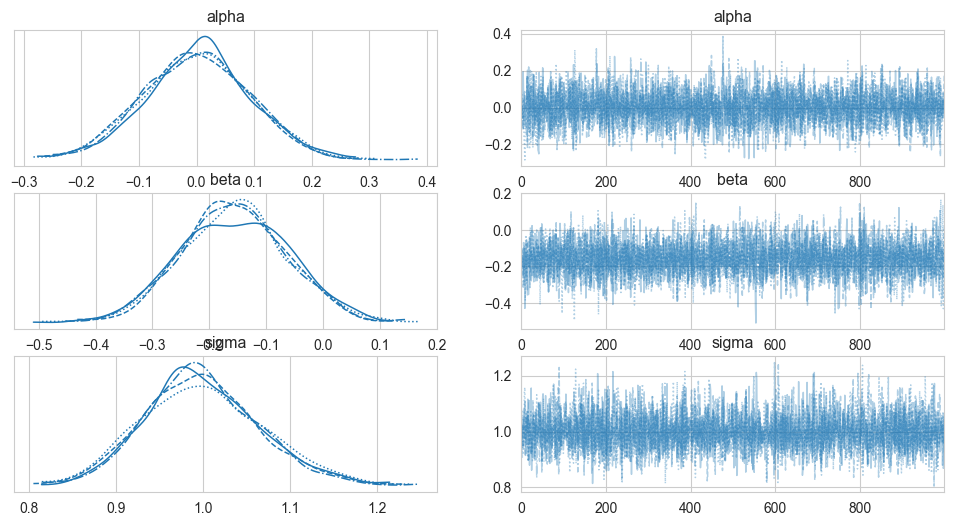

In [32]:
with basic_model:
    idata_posterior = pm.sample(draws=1000)

az.plot_trace(idata_posterior["posterior"])

Sampling: [weight]


Output()

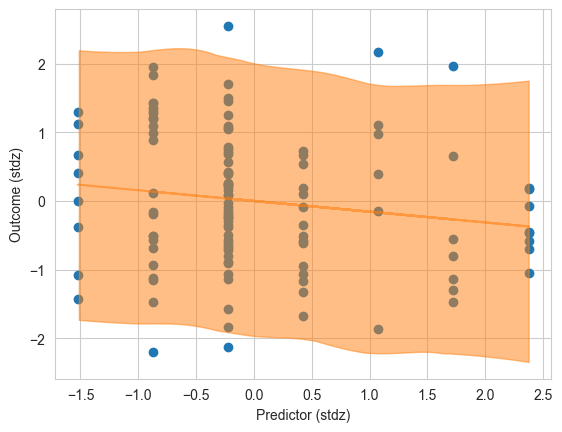

In [33]:
with basic_model:
    pm.sample_posterior_predictive(idata_posterior, extend_inferencedata=True)

post = idata_posterior.posterior
mu_pp = post["alpha"] + post["beta"] * xr.DataArray(df_foxes["groupsize"].to_numpy(), dims=["obs_id"])

_, ax = plt.subplots()

ax.plot(
    df_foxes["groupsize"].to_numpy(), mu_pp.mean(("chain", "draw")), label="Mean outcome", color="C1", alpha=0.6
)
ax.scatter(df_foxes["groupsize"].to_numpy(), idata_posterior.observed_data["weight"])
az.plot_hdi(df_foxes["groupsize"].to_numpy(), idata_posterior.posterior_predictive["weight"], hdi_prob=0.95)

ax.set_xlabel("Predictor (stdz)")
ax.set_ylabel("Outcome (stdz)");